In [79]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [80]:
# 1. 데이터셋 불러오기
df = pd.read_csv('C:/Users/seohe/OneDrive/바탕 화면/Thesis/dataset_user.csv')

In [81]:
# data를 0으로 채우기
df = df.fillna(0)

In [82]:
# 2. 특징 벡터 추출
X = df[['Activity', 'Location Frequency', 'Main Activity Time']].values

In [9]:
# dtype을 'int128'로 설정하여 ValueError 회피
# 데이터 타입 변경
# feature_vector = df.astype('float64') 

In [83]:
# 3. 코사인 유사도 계산
cos_sim = cosine_similarity(X)

In [84]:
# 4. FCM 알고리즘 적용
# 클러스터링 모델 생성
kmeans = KMeans(n_clusters=2, random_state=0).fit(cos_sim)


In [85]:
# 5. 클러스터링 결과 출력
clusters = kmeans.labels_
clustered_data = pd.concat([df, pd.DataFrame({'Cluster': clusters})], axis=1)
print(clustered_data.groupby('Cluster')['User ID'].apply(list))

Cluster
0    [2, 3, 4, 8, 9, 10, 14, 15, 16, 17, 18, 20, 21...
1    [1, 7, 11, 12, 19, 30, 43, 45, 71, 73, 74, 84,...
Name: User ID, dtype: object


<AxesSubplot:>

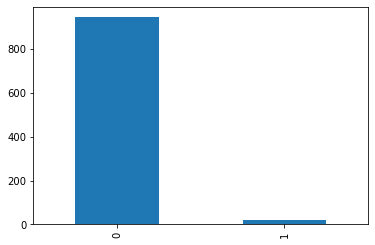

In [86]:
# 6. 시각화
clustered_data['Cluster'].value_counts().plot(kind='bar')

각 집단 알고리즘 적용

In [19]:
clustered_data.to_csv('./dataset_cluster.csv')
# 라벨(0,1) 중심으로 필터링 - 오름차순
# [:946] 라벨 0
# [946:] 라벨 1

In [87]:
# KMeans 알고리즘 적용
kmeans = KMeans(n_clusters=2, random_state=42).fit(clustered_data)

# 클러스터 중심값 출력
print(kmeans.cluster_centers_)

[[2.70908350e+02 1.43767821e+01 2.45000000e+02 2.85947047e+00
  3.66598778e-02]
 [8.15460722e+02 1.16242038e+01 7.26000000e+02 3.40127389e+00
  6.93889390e-18]]


In [88]:
data = pd.read_csv('C:/Users/seohe/OneDrive/바탕 화면/Thesis/dataset_cluster.csv')

In [34]:
data[:944].to_csv('./dataset_label0.csv')
data[944:].to_csv('./dataset_label1.csv')

인액티브 집단 : label 0

In [89]:
# 1. inactive 유저들을 포함하는 클러스터 선택
inactive_cluster = clustered_data[clustered_data['Cluster'] == 0]

In [36]:
# 2. 클러스터 내에서 가장 중심이 되는 위치 찾기
center_lat = inactive_cluster['Latitude'].mean()
center_lon = inactive_cluster['Longitude'].mean()

KeyError: 'Latitude'

In [90]:
# cluster_0.csv 파일 읽기
cluster_0 = pd.read_csv("C:/Users/seohe/OneDrive/바탕 화면/Thesis/cluster_0.csv")

# foursquare_dataset2.csv 파일 읽기
foursquare = pd.read_csv("C:/Users/seohe/OneDrive/바탕 화면/Thesis/dataset_0.csv")

# user id를 기준으로 두 데이터프레임 병합
merged_df = pd.merge(cluster_0, foursquare, on="User ID", how="inner")

In [91]:
merged_df.to_csv('./dataset_cluster_0.csv')
# unnamed 삭제 후 저장

In [92]:
!pip install haversine

In [93]:
from haversine import haversine, Unit

In [94]:
# inactive 유저들의 위도, 경도 정보
inactive_users = pd.read_csv('dataset_cluster_0.csv')

In [95]:
# POI 데이터셋에서 필요한 열만 추출
poi = pd.read_csv('dataset_cluster_0.csv')[['Venue ID', 'Latitude', 'Longitude']]

In [96]:
# inactive 유저들의 위치에서 반경 20km 이내에 있는 POI 추출
filtered_poi = []

In [47]:
for i, row in inactive_users.iterrows():
    user_location = (row['Latitude'], row['Longitude'])
    for j, poi_row in poi.iterrows():
        poi_location = (poi_row['Latitude'], poi_row['Longitude'])
        distance = haversine(user_location, poi_location, unit=Unit.KILOMETERS)
        if distance <= 20:
            filtered_poi.append(poi_row.to_dict())


KeyboardInterrupt: 

100개만 test

In [97]:
cluster100 = pd.read_csv("C:/Users/seohe/OneDrive/바탕 화면/Thesis/dataset_cluster_0.csv")

In [98]:
cluster100[:100].to_csv('C:/Users/seohe/OneDrive/바탕 화면/Thesis/cluster_100.csv')

In [99]:
# inactive 유저들의 위도, 경도 정보
inactive_users = pd.read_csv('C:/Users/seohe/OneDrive/바탕 화면/Thesis/cluster_100.csv')

In [100]:
# POI 데이터셋에서 필요한 열만 추출
poi = pd.read_csv('dataset_cluster_0.csv')[['User ID', 'Venue ID', 'Latitude', 'Longitude']]

In [101]:
# inactive 유저들의 위치에서 반경 20km 이내에 있는 POI 추출
filtered_poi = []

In [102]:
# POI 위치를 튜플 형태로 저장
poi_locations = [(row['Latitude'], row['Longitude']) for _, row in poi.iterrows()]


In [103]:
# POI 위치를 기준으로 인근 POI 필터링
for _, row in inactive_users.iterrows():
    user_location = (row['Latitude'], row['Longitude'])
    distances = [haversine(user_location, poi_location, unit=Unit.KILOMETERS) for poi_location in poi_locations]
    filtered_indices = [i for i, distance in enumerate(distances) if distance <= 20]
    filtered_poi += poi.iloc[filtered_indices].to_dict('records')

In [104]:
filtered_poi = pd.DataFrame(filtered_poi)

In [73]:
# print(filtered_poi[:3])

In [105]:
user_poi_matrix = {}
for i, row in filtered_poi.iterrows():
    poi_id = row['Venue ID']
    if poi_id not in user_poi_matrix:
        user_poi_matrix[poi_id] = set()
    user_poi_matrix[poi_id].add(row['User ID'])

In [106]:
# 추천할 POI 개수
k = 10

# 각 POI를 방문한 사용자 수를 세어서 데이터프레임으로 만듦
poi_visits = pd.DataFrame({'POI ID': list(user_poi_matrix.keys()), 'visits': [len(users) for users in user_poi_matrix.values()]})

# 방문자 수가 많은 k개의 POI를 추천
top_poi = poi_visits.sort_values(by='visits', ascending=False).head(k)['POI ID'].values.tolist()

In [107]:
print(top_poi)

['42911d00f964a520f5231fe3', '42829c80f964a5206a221fe3', '43a52546f964a520532c1fe3', '4ace6c89f964a52078d020e3', '3fd66200f964a520def11ee3', '3fd66200f964a520ddf01ee3', '4db44994cda1c57c82583709', '4fa4a231e4b09571de93b9a7', '49b7ed6df964a52030531fe3', '4f93baf21081cba0060643f0']


In [108]:
print(poi_visits[:20])

                      POI ID  visits
0   4ef372169adf60f8399b4bd7       3
1   49cbb6f9f964a5200f591fe3      14
2   4b194ddaf964a520efda23e3       1
3   4b004fc9f964a520ab3c22e3       1
4   4a1c91b1f964a520527b1fe3       5
5   4d48864b551db1f722e9a330       2
6   4ee3d902a69d89905b82e7e5       1
7   4a3df25ff964a520c2a21fe3       3
8   4b8f50d9f964a520365133e3       4
9   4b4c9bf6f964a52078b726e3       1
10  4a4d10fbf964a52082ad1fe3      12
11  4a62bb49f964a5207bc41fe3       1
12  4f5afb6ee4b02628c0a936d6       1
13  4a478d19f964a520d2a91fe3      16
14  4b086783f964a520250b23e3       2
15  4c099260a1b32d7fd3f497f0       1
16  4e95fe144901d620b78076f2       1
17  4b242ae5f964a520b76224e3       4
18  42508380f964a520c1201fe3       1
19  4a43c0aef964a520c6a61fe3      17


액티브 집단 : label 1

In [109]:
import pandas as pd
from sklearn.neighbors import KernelDensity

In [110]:
# 1. 라벨링 1로 된 클러스터 데이터셋과 Foursquare 데이터셋2 불러오기
cluster_data = pd.read_csv('C:/Users/seohe/OneDrive/바탕 화면/Thesis/cluster_1.csv')
foursquare_data = pd.read_csv('C:/Users/seohe/OneDrive/바탕 화면/Thesis/dataset_0.csv')

In [111]:
# userID 기준으로 라벨링 1 추출하고 두개 합치기# cluster_0.csv 파일 읽기
# cluster_0 = pd.read_csv("C:/Users/seohe/OneDrive/바탕 화면/Thesis/cluster_1.csv")

# foursquare_dataset2.csv 파일 읽기
# foursquare = pd.read_csv("C:/Users/seohe/OneDrive/바탕 화면/Thesis/dataset_0.csv")

# user id를 기준으로 두 데이터프레임 병합
merged_df = pd.merge(clustered_data, foursquare_data, on="User ID", how="inner")

In [115]:
merged_df.to_csv('./dataset_cluster_1.csv')
# unnamed 삭제 후 저장

In [144]:
dataset_cluster_1 =  pd.read_csv('C:/Users/seohe/OneDrive/바탕 화면/Thesis/dataset_cluster_1.csv')

In [145]:
# 2. 클러스터 데이터셋에서 각 유저의 활동 빈도수, POI 방문 횟수, 주 활동 시간대 추출하기
cluster_user_data = dataset_cluster_1[['User ID', 'Activity', 'Location Frequency', 'Main Activity Time']].drop_duplicates()

In [146]:
# 3. KDE 함수 학습시키기
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
kde.fit(cluster_user_data[['Activity', 'Location Frequency', 'Main Activity Time']])

KernelDensity(bandwidth=0.2)

In [147]:
# 4. 추천 대상 유저의 위치 정보 추출하기
target_user_latitude, target_user_longitude = (37.1234, 126.5678)

In [135]:
# score_samples = dataset_cluster_1[:100]

In [148]:
# 5. 거리선호도 계산하기
target_user_activity_frequency = 10 # 예시로 10으로 설정
target_user_poi_visits = 20 # 예시로 20으로 설정
target_user_primary_time = 15 # 예시로 15로 설정

target_user_score = kde.score_samples([[target_user_activity_frequency, target_user_poi_visits, target_user_primary_time]])

In [149]:
import numpy as np

In [152]:
target_user_data = np.array([[target_user_latitude, target_user_longitude]])
# target_user_score = kde.score_samples(target_user_data)
recommended_poi = foursquare_data[['Latitude', 'Longitude']].copy()
recommended_poi['score'] = kde.score_samples(foursquare_data[['Latitude', 'Longitude']])
recommended_poi = recommended_poi.sort_values('score', ascending=False).head(k)


ValueError: query data dimension must match training data dimension

In [153]:
# 6. 거리선호도가 높은 상위 k개의 POI 추천하기
foursquare_data['score'] = kde.score_samples(foursquare_data[['Latitude', 'Longitude']])
recommended_poi = foursquare_data.sort_values('score', ascending=False).head(k)

ValueError: query data dimension must match training data dimension